# Clustering in two dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from functions import gen_domains2D, plot_domains2D, confidence_ellipse

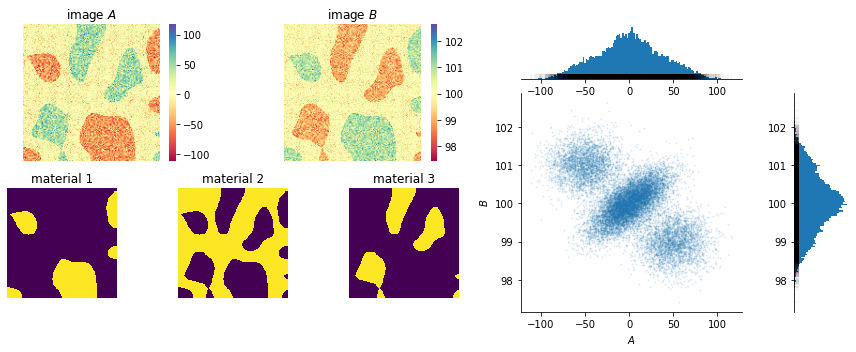

In [2]:
images, materials = gen_domains2D(
    populations=(1, 3, 1),
    means=((-50, 101), (0, 100), (50, 99)),
    stds=((10, 1/5), (10, 1/5), (10, 1/5)),
    pearsons=(0, 0.4, 0)
);
plot_domains2D(images, materials);

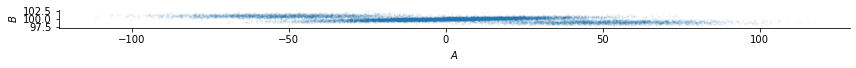

In [3]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(*images.reshape(2, -1), alpha=0.05, s=1)
ax.set(
    xlabel='$A$',
    ylabel='$B$',
    aspect='equal'
)
for side in ('top', 'right'):
    ax.spines[side].set_visible(False)
fig.tight_layout()

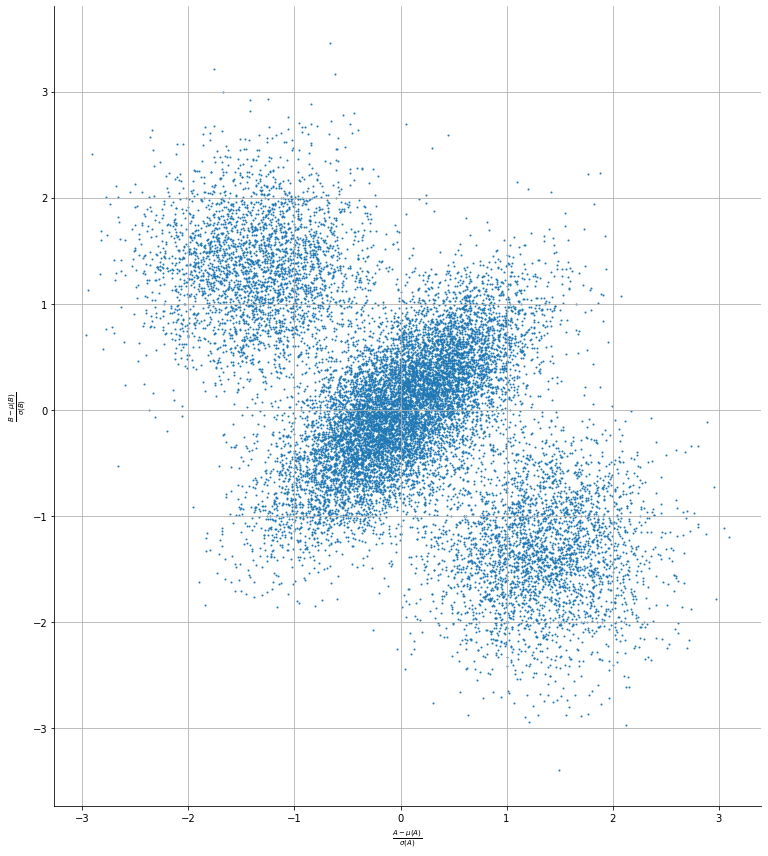

In [4]:
mahalanobis = (
    (images - images.mean(axis=(1, 2))[:, np.newaxis, np.newaxis])
    / images.std(axis=(1, 2))[:, np.newaxis, np.newaxis]
)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(*mahalanobis.reshape(2, -1), s=1)
ax.set(
    xlabel=r'$\frac{A-{\mu}(A)}{{\sigma}(A)}$',
    ylabel=r'$\frac{B-{\mu}(B)}{{\sigma}(B)}$',
    aspect='equal'
)
ax.grid()
for side in ('top', 'right'):
    ax.spines[side].set_visible(False)
fig.tight_layout()

In [5]:
images_top = images[:, :64]
materials_top = [mat[:64] for mat in materials]
images_bottom = images[:, 64:]
materials_bottom = [mat[64:] for mat in materials]

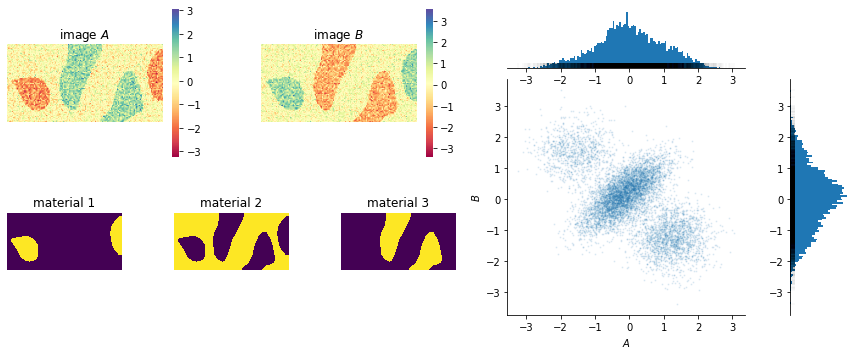

In [6]:
norm_top = (
    (images_top - images_top.mean(axis=(1, 2))[:, np.newaxis, np.newaxis])
    / images_top.std(axis=(1, 2))[:, np.newaxis, np.newaxis]
)
plot_domains2D(norm_top, materials_top);

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3).fit(norm_top.reshape(2, -1).T)
labels_top = gmm.predict(norm_top.reshape(2, -1).T)
probs_top = gmm.predict_proba(norm_top.reshape(2, -1).T)

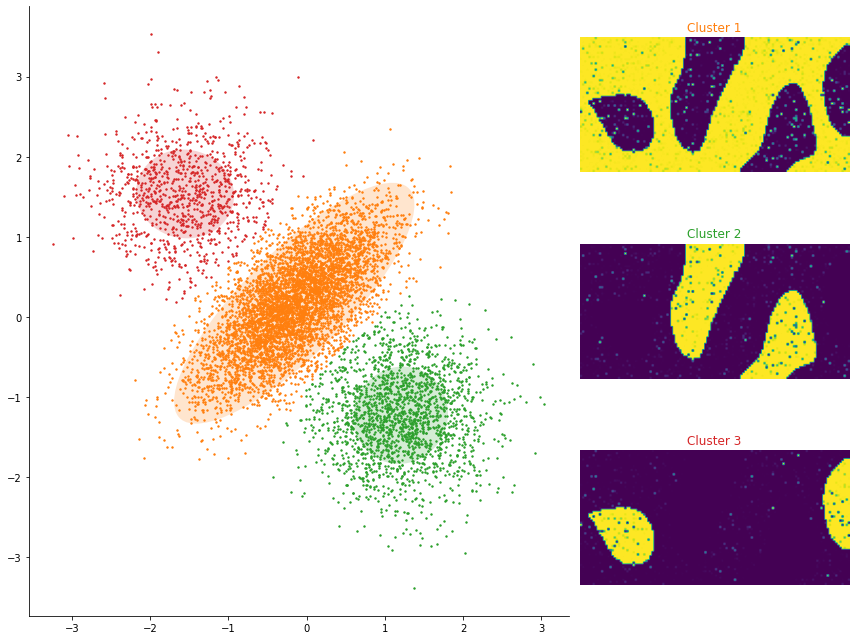

In [8]:
fig = plt.figure(figsize=(12, 9))
gs = plt.GridSpec(figure=fig, nrows=3, ncols=2, width_ratios=(2, 1))
scatter_ax = fig.add_subplot(gs[:, 0])
cluster_axes = [fig.add_subplot(gs[i, -1]) for i in range(3)]
for i in range(3):
    c = f'C{i+1}'
    scatter_ax.scatter(*norm_top.reshape(2, -1)[:, labels_top==i], c=c, s=2)
    confidence_ellipse(scatter_ax, gmm.means_[i], gmm.covariances_[i], fc=c, ls='--', lw=2, alpha=0.2)
    cluster_axes[i].imshow(probs_top[:, i].reshape(images_top[0].shape))
    cluster_axes[i].set_title(f'Cluster {i+1}', c=c)
    cluster_axes[i].set_axis_off()
for side in ('top', 'right'):
    scatter_ax.spines[side].set_visible(False)
fig.tight_layout()

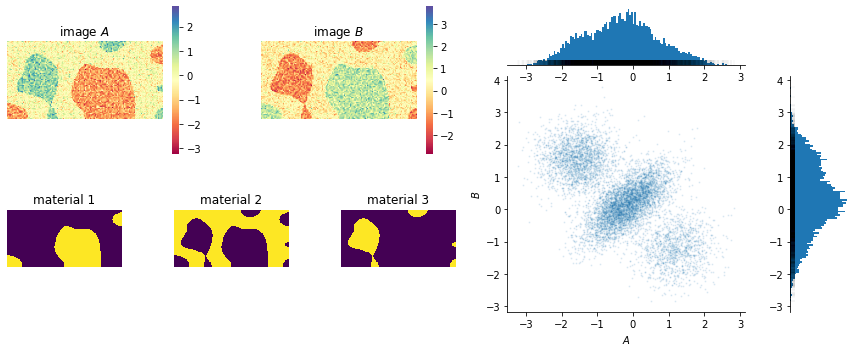

In [9]:
norm_bottom = (
    (images_bottom - images_top.mean(axis=(1, 2))[:, np.newaxis, np.newaxis])
    / images_top.std(axis=(1, 2))[:, np.newaxis, np.newaxis]
)
plot_domains2D(norm_bottom, materials_bottom);

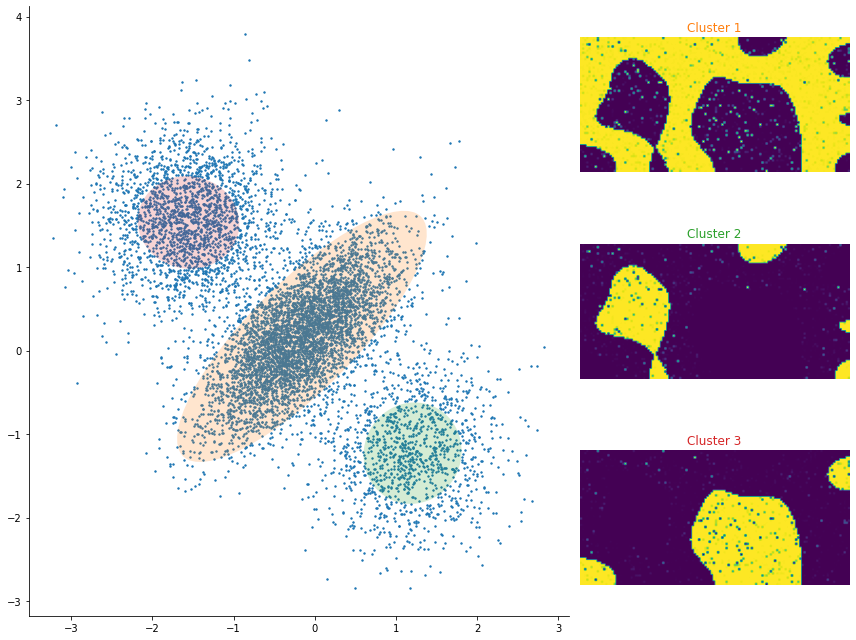

In [10]:
probs_bottom = gmm.predict_proba(norm_bottom.reshape(2, -1).T)
fig = plt.figure(figsize=(12, 9))
gs = plt.GridSpec(figure=fig, nrows=3, ncols=2, width_ratios=(2, 1))
scatter_ax = fig.add_subplot(gs[:, 0])
cluster_axes = [fig.add_subplot(gs[i, -1]) for i in range(3)]
scatter_ax.scatter(*norm_bottom.reshape(2, -1), c='C0', s=2)
for i in range(3):
    c = f'C{i+1}'
    confidence_ellipse(scatter_ax, gmm.means_[i], gmm.covariances_[i], fc=c, ls='--', lw=2, alpha=0.2)
    cluster_axes[i].imshow(probs_bottom[:, i].reshape(images_bottom[0].shape))
    cluster_axes[i].set_title(f'Cluster {i+1}', c=c)
    cluster_axes[i].set_axis_off()
for side in ('top', 'right'):
    scatter_ax.spines[side].set_visible(False)
fig.tight_layout()